 # PtyRAD - PTYchographic Reconstruction with Automatic Differentiation

 Chia-Hao Lee

cl2696@cornell.edu

Created 2024.03.08

# 01. Imports

In [2]:
%reload_ext autoreload
%autoreload 2

import os
import matplotlib.pyplot as plt

import numpy as np
import torch
from tifffile import imread, imwrite

GPUID = 0
DEVICE = torch.device('cuda:' + str(GPUID))
print('Execution device: ', DEVICE)
print('PyTorch version: ', torch.__version__)
print('CUDA available: ', torch.cuda.is_available())
print('CUDA version: ', torch.version.cuda)
print('CUDA device:', torch.cuda.get_device_name(GPUID))

Execution device:  cuda:0
PyTorch version:  2.2.2
CUDA available:  True
CUDA version:  12.1
CUDA device: Quadro P5000


In [3]:
from ptyrad.initialization import Initializer
from ptyrad.models import PtychoAD
from ptyrad.optimization import CombinedLoss, CombinedConstraint, ptycho_recon, loss_logger
from ptyrad.visualization import plot_forward_pass, plot_scan_positions, plot_affine_transformation
from ptyrad.utils import test_loss_fn, make_batches, make_save_dict, make_recon_params_dict, shuffle_batches, get_size_bytes, time_sync, compose_affine_matrix

Importing from ptyrad


h:\workspace\p01_code\deep_ptycho\ptyrad\ptyrad\initialization.py:166: SyntaxWarning: list indices must be integers or slices, not str; perhaps you missed a comma?
  N_scan_slow = ['exp_params']['N_scan_slow']
h:\workspace\p01_code\deep_ptycho\ptyrad\ptyrad\initialization.py:167: SyntaxWarning: list indices must be integers or slices, not str; perhaps you missed a comma?
  N_scan_fast = ['exp_params']['N_scan_fast']
h:\workspace\p01_code\deep_ptycho\ptyrad\ptyrad\initialization.py:193: SyntaxWarning: list indices must be integers or slices, not str; perhaps you missed a comma?
  dx_spec        = ['exp_params']['dx_spec']
h:\workspace\p01_code\deep_ptycho\ptyrad\ptyrad\initialization.py:194: SyntaxWarning: list indices must be integers or slices, not str; perhaps you missed a comma?
  scan_step_size = ['exp_params']['scan_step_size']


# 02. Initialize optimization

In [ ]:
#from ptyrad.demos.params_CNS import exp_params, source_params
#from ptyrad.demos.params_PSO_128 import exp_params, source_params
#from ptyrad.demos.params_PSO_256 import exp_params, source_params
#from ptyrad.demos.params_tBL_WSe2 import exp_params, source_params
#from ptyrad.demos.params_BaM_128 import exp_params, source_params

In [33]:
# CNS

exp_CBED_path      = 'data/CNS_from_Hari/240327_fov_23p044A_x_24p402A_thickness_9p978A_step0p28_conv30_dfm100_det70_TDS_2configs_xdirection_Co_0p25_Nb_0_S_0.mat' 
ptycho_output_path = 'data/CNS_from_Hari/Niter10000.mat'

exp_params = {
    'kv'                : 300,  # kV
    'conv_angle'        : 30, # mrad, semi-convergence angle
    'Npix'              : 164, # Detector pixel number, EMPAD is 128. Only supports square detector for simplicity
    'rbf'               : None, # Pixels of radius of BF disk, used to calculate dk
    'dx_spec'           : 0.1406,# Ang
    'defocus'           : -100, # Ang, positive defocus here refers to actual underfocus or weaker lens strength following Kirkland/abtem/ptychoshelves convention
    'c3'                : 0, # Ang, spherical aberration coefficients
    'z_distance'        : 1.25, # Ang
    'Nlayer'            : 8,
    'N_scans'           : 7134,
    'N_scan_slow'       : 87,
    'N_scan_fast'       : 82,
    'scan_step_size'    : 0.28, # Ang
    'scan_flip'         : None, #(2)
    'scan_affine'       : (1, 0, 1, 0),# #None, # (scale, asymmetry, rotation, shear)
    'omode_max'         : 1,
    'pmode_max'         : 2,
    'pmode_init_pows'   : [0.02],
    'probe_permute'     : None,
    'cbeds_permute'     : (0,1,3,2),
    'cbeds_reshape'     : (7134,164,164),
    'cbeds_flip'        : None,
    'probe_simu_params' : None
    }

# Source and params, note that these should be changed in accordance with each other
source_params = {
    'measurements_source': 'mat',
    'measurements_params': [exp_CBED_path, 'cbed'],
    'obj_source'         : 'simu', #'PtyShv',
    'obj_params'         : None, #ptycho_output_path, #(1,8,391,403),
    'probe_source'       : 'simu',
    'probe_params'       : None, 
    'pos_source'         : 'simu',
    'pos_params'         : None,
    'omode_occu_source'  : 'uniform',
    'omode_occu_params'  : None
}

In [34]:
init = Initializer(exp_params, source_params).init_all()


### Initializing cache ###
use_cached_obj   = False
use_cached_probe = False
use_cached_pos   = False

### Initializing exp_params ###
Input values are displayed below:
kv: 300
conv_angle: 30
Npix: 164
rbf: None
dx_spec: 0.1406
defocus: -100
c3: 0
z_distance: 1.25
Nlayer: 8
N_scans: 7134
N_scan_slow: 87
N_scan_fast: 82
scan_step_size: 0.28
scan_flip: None
scan_affine: (1, 0, 1, 0)
omode_max: 1
pmode_max: 2
pmode_init_pows: [0.02]
probe_permute: None
cbeds_permute: (0, 1, 3, 2)
cbeds_reshape: (7134, 164, 164)
cbeds_flip: None
probe_simu_params: None
Derived values given input exp_params:
kv          = 300 kV
wavelength  = 0.0197 Ang
conv_angle  = 30 mrad
Npix        = 164 px
dk          = 0.0434 Ang^-1
kMax        = 3.5562 Ang^-1
alpha_max   = 70.0124 mrad
dx          = 0.1406 Ang, Nyquist-limited dmin = 2*dx = 0.2812 Ang
Rayleigh-limited resolution  = 0.4003 Ang (0.61*lambda/alpha for focused probe )
Real space extent = 23.0584 Ang

### Initializing measurements from 'mat' ###
Can't l

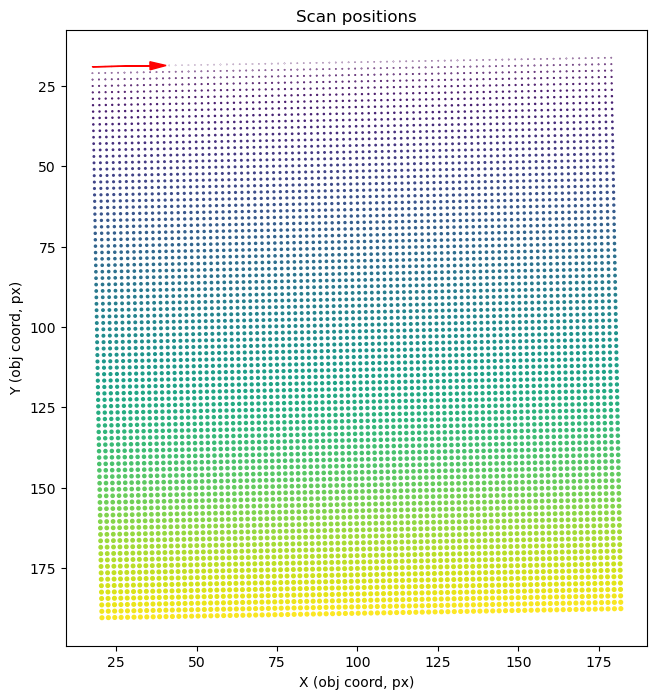

In [35]:
pos = init.init_variables['crop_pos'] + init.init_variables['probe_pos_shifts']
plot_scan_positions(pos)

In [ ]:
model_params = {
    'init_variables': init.init_variables,
    'detector_blur_std': None,
    'lr_params':{
        'obja': 1e-3,
        'objp': 1e-3,
        'probe': 1e-3, 
        'probe_pos_shifts': 1e-3}}

model = PtychoAD(model_params, device=DEVICE)

# Use model.set_optimizer(new_lr_params) to update the variable flag and optimizer_params
optimizer = torch.optim.Adam(model.optimizer_params)

In [ ]:
# # Use this to edit learning rate if needed some refinement

# model.set_optimizer(lr_params={'obja': 1e-4,
#                                'objp': 1e-4,
#                                'probe': 1e-4, 
#                                'probe_pos_shifts': 1e-2})
# optimizer=torch.optim.Adam(model.optimizer_params)

## Check the forward pass

In [ ]:
indices = np.random.randint(0,exp_params['N_scans'],2)
dp_power = 0.5

plot_forward_pass(model, indices, dp_power, init.init_variables['obj'])

## Finetune the loss params

In [ ]:
loss_params = {
    'loss_single': {'state':  True,  'weight': 1.0, 'dp_pow': 0.5},
    'loss_pacbed': {'state': False,  'weight': 1.0, 'dp_pow': 0.2},
    'loss_tv'    : {'state': False,  'weight': 1e-5},
    'loss_l1'    : {'state': False,   'weight': 0.1},
    'loss_l2'    : {'state': False,  'weight': 1.0},
    'loss_postiv': {'state':  False,  'weight': 1.0}
}

indices = np.random.randint(0,exp_params['N_scans'],64)
loss_fn = CombinedLoss(loss_params, device=DEVICE)
test_loss_fn(model, indices, loss_fn)

# Setup the iteration-wise constraint params

In [ ]:
constraint_params = {
    'ortho_pmode'   : {'freq': 1},
    'ortho_omode'   : {'freq': None},
    'kz_filter'     : {'freq': 1, 'beta':1, 'alpha':1, 'z_pad':None},
    'postiv'        : {'freq': 1},
    'fix_probe_int' : {'freq': 1}
}

constraint_fn = CombinedConstraint(constraint_params, device=DEVICE)

# 03. Main optimization loop

In [ ]:
NITER = 10
BATCH_SIZE = 256
GROUP = 'random' #'sparse'


indices = np.arange(model.measurements.size(0))
pos = model.crop_pos.cpu().numpy()
batches = make_batches(indices, pos, BATCH_SIZE, group = GROUP)

# output_path = f"output/BaM/{model.opt_objp.size(0)}obj_{model.opt_objp.size(1)}slice_N{len(indices)}_dp{model.measurements.size(1)}_lr{model_params['lr_params']['objp']:.0e}_b{BATCH_SIZE}_{GROUP}/"
# print(f"output_path = {output_path}")
# os.makedirs(output_path, exist_ok=True)
# recon_params = make_recon_params_dict(NITER, BATCH_SIZE, GROUP, batches, output_path)

loss_iters = []
for iter in range(1, NITER+1):
    
    batches = shuffle_batches(batches, BATCH_SIZE, GROUP)
    batch_losses, iter_t = ptycho_recon(batches, model, optimizer, loss_fn, constraint_fn, iter)
    loss_iters.append((iter, loss_logger(batch_losses, iter, iter_t)))
    
    # ## Saving
    # if iter % 5 == 0:
    #     save_dict = make_save_dict(model, exp_params, source_params, loss_params, constraint_params, recon_params, loss_iters, iter_t, iter, batch_losses)
    #     torch.save(save_dict, os.path.join(output_path, f"model_iter{str(iter).zfill(4)}.pt"))
    #     imwrite(os.path.join(output_path, f"objp_iter{str(iter).zfill(4)}.tif"), model.opt_objp[0].detach().cpu().numpy().astype('float32'))
    #     imwrite(os.path.join(output_path, f"probe_amp_iter{str(iter).zfill(4)}.tif"), model.opt_probe.reshape(-1, model.opt_probe.size(-1)).t().abs().detach().cpu().numpy().astype('float32'))

In [ ]:
# Quick plot of the loss curve
plt.figure()
plt.plot(np.array(loss_iters)[:,1])
plt.show()

In [ ]:
# Comparing the initial probe intensity, CBED intensity, and optimized probe int
init_probe_int = np.sum(np.abs(init.init_variables['probe'])**2)
init_CBED_int = np.sum(np.mean(init.init_variables['measurements'], 0))
opt_probe_int = model.opt_probe.abs().pow(2).sum().detach().cpu().numpy()
print(f"{init_probe_int}, {init_CBED_int}, {opt_probe_int}")

In [ ]:
# Visualize the probe modes
init_probe = init.init_variables['probe']
opt_probe = model.opt_probe.detach().cpu().numpy()
fig, axs = plt.subplots(2, len(opt_probe), figsize=(len(opt_probe)*2.5, 6))
for i in range(len(opt_probe)):
    ax_init = axs[0, i]
    ax_init.set_title(f"Init probe {i}")
    im_init = ax_init.imshow(np.abs(init_probe[i]))
    ax_init.axis('off')
    plt.colorbar(im_init, ax=ax_init, shrink=0.6)

    ax_opt = axs[1, i]
    ax_opt.set_title(f"Opt probe {i}")
    im_opt = ax_opt.imshow(np.abs(opt_probe[i]))
    ax_opt.axis('off')
    plt.colorbar(im_opt, ax=ax_opt, shrink=0.6)

plt.tight_layout()
plt.show()